<a href="https://colab.research.google.com/github/fjme95/python-para-la-ciencia-de-datos/blob/main/Semana%201/LDA_Clasificaci%C3%B3n_de_default.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Objetivo

En este notebook veremos todos los pasos necesarios para aplicar clasificar si una persona entrará en default (no pagará) un préstamo. 

Que un individuo (o empresa, asociación, etc.) entre en **default** quiere decir que falló en pagar su deuda. Predecir a los individuos con mayor probabilidad de entrar en este estado, ayuda a planear estrategias sobre las inversiones que se realizarán (préstamos en este caso).

Para clasificar, usaremos Linear Discriminant Analysis (LDA).

Estos pasos comprenden:

1. Obtención de los datos
2. Limpieza y preparación de los datos
    1. Valores nulos
    2. Tipos de variables
    3. Variables con poca variación
    4. Variables con alta correlación 
    5. Creación de variables dummy
    6. Imputación de datos faltantes
3. Entrenamiento y evaluación del modelo obtenido con LDA.
4. LDA como reductor de la dimensión


El propósito de la limpieza y preparación de los datos, es conseguir un DataFrame (o matriz) que podamos usar en el algoritmo. 



# Dependencias

In [1]:
%%capture
!pip install -U plotly

In [2]:
from pprint import pprint

import pandas as pd
import numpy as np

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix

import plotly.express as px

In [3]:
sep= "\n-------------------\n"

# Datos

Trabajaremos con datos del Lending Club.

Lending Club es una plataforma de préstamos entre pares (P2P), donde los prestatarios envían sus solicitudes de préstamo y los prestamistas individuales seleccionan las solicitudes que desean financiar. Los prestatarios reciben el monto total del préstamo emitido menos la tarifa inicial, que se paga a la empresa. Los inversores compran notas respaldadas por préstamos personales y pagan a Lending Club una tarifa de servicio.

Los préstamos P2P reducen el costo de los préstamos personales en comparación con el financiamiento tradicional al conectar directamente a los prestatarios e inversores. Sin embargo, siempre existe el riesgo de invertir en un préstamo incobrable. De hecho, la tasa de incumplimiento de los préstamos P2P es mucho más alta que la de los préstamos tradicionales. Por lo tanto, la industria crediticia está muy interesada en brindar a los inversionistas una evaluación integral del riesgo de las solicitudes de préstamo. La empresa comparte datos sobre todas las solicitudes de préstamos realizadas a través de su plataforma.

La descripción de las variables en el dataset se puede descargar [aqui](http://www-2.rotman.utoronto.ca/~hull/mlbook/lendingclub_datadictionary.xlsx).


## Descarga de los datos

In [4]:
!mkdir data
!wget http://www-2.rotman.utoronto.ca/~hull/mlbook/lending_clubFull_Data_Set.xlsx -O data/lending_club.xlsx

--2021-12-10 23:14:44--  http://www-2.rotman.utoronto.ca/~hull/mlbook/lending_clubFull_Data_Set.xlsx
Resolving www-2.rotman.utoronto.ca (www-2.rotman.utoronto.ca)... 128.100.40.235
Connecting to www-2.rotman.utoronto.ca (www-2.rotman.utoronto.ca)|128.100.40.235|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10008453 (9.5M) [application/vnd.openxmlformats-officedocument.spreadsheetml.sheet]
Saving to: ‘data/lending_club.xlsx’

data/lending_club.x 100%[===================>]   9.54M   389KB/s    in 25s     

2021-12-10 23:15:10 (385 KB/s) - ‘data/lending_club.xlsx’ saved [10008453/10008453]



## Lectura de los datos

In [5]:
data_raw = pd.read_excel("data/lending_club.xlsx", index_col=0)
data_raw

,id,member_id,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,...,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,263591,545710,20000.0,60 months,17.93,342.94,E,E5,Wylie ISD,1 year,MORTGAGE,44304.0,Verified,Charged Off,n,NaN,debt_consolidation,Todd's Loan,750xx,TX,18.47,0.0,1995-11-01,690.0,694.0,0.0,33.0,NaN,6.0,0.0,5673.0,97.8,20.0,f,NaT,2016-10-01,594.0,590.0,0.0,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,NaN
1,1613916,69664096,30000.0,36 months,11.99,996.29,C,C1,Sergeant,10+ years,MORTGAGE,136000.0,Verified,Current,n,NaN,debt_consolidation,Debt consolidation,080xx,NJ,20.63,3.0,2003-10-01,670.0,674.0,1.0,7.0,73.0,12.0,1.0,13383.0,40.7,34.0,f,2018-01-01,2017-12-01,739.0,735.0,0.0,16.0,...,1.0,0.0,116075.0,69594.0,27500.0,83175.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,NaN
2,818934,8965180,21500.0,36 months,11.99,714.01,B,B3,Designer,1 year,RENT,50000.0,Source Verified,Fully Paid,n,Borrower added on 11/24/13 > We are consolid...,debt_consolidation,Debt Be Gone,760xx,TX,29.62,0.0,1999-10-01,735.0,739.0,1.0,NaN,NaN,13.0,0.0,14071.0,36.2,44.0,w,NaT,2017-03-01,704.0,700.0,0.0,NaN,...,0.0,0.0,116920.0,74939.0,19700.0,78020.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,NaN
3,1606612,70572960,10000.0,36 months,13.67,340.18,C,C3,NaN,NaN,RENT,64400.0,Source Verified,Fully Paid,n,NaN,debt_consolidation,Debt consolidation,029xx,RI,16.68,3.0,1983-11-01,675.0,679.0,0.0,8.0,NaN,9.0,0.0,8057.0,57.5,20.0,w,NaT,2017-12-01,669.0,665.0,0.0,32.0,...,0.0,0.0,39547.0,16824.0,11200.0,25547.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,NaN
4,1639932,68589517,5000.0,36 months,8.49,157.82,B,B1,Sr. Manufacturing Engineer,10+ years,MORTGAGE,88000.0,Source Verified,Current,n,NaN,debt_consolidation,Debt consolidation,301xx,GA,5.32,0.0,2000-04-01,660.0,664.0,0.0,27.0,NaN,4.0,0.0,3055.0,92.6,5.0,w,2018-01-01,2017-12-01,699.0,695.0,0.0,NaN,...,0.0,0.0,104310.0,7582.0,3300.0,13015.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,901888,4974773,10500.0

## Datos Faltantes

In [6]:
na_values = (data_raw.isna().sum().sort_values() / len(data_raw)).reset_index(name = 'n')
na_values

,index,n
0,id,0.00000
1,member_id,0.00000
2,initial_list_status,0.00004
3,last_fico_range_low,0.00004
4,revol_bal,0.00004
...,...,...
129,hardship_status,0.99616
130,hardship_reason,0.99616
131,hardship_type,0.99616
132,deferral_term,0.99616


In [7]:
px.bar(na_values, "index", "n")

In [8]:
data_filt = data_raw.loc[:, data_raw.columns[na_values.n < .1]]
data_filt

,id,member_id,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq
0,263591,545710,20000.0,60 months,17.93,342.94,E,E5,Wylie ISD,1 year,MORTGAGE,44304.0,Verified,Charged Off,n,NaN,debt_consolidation,Todd's Loan,750xx,TX,18.47,0.0,1995-11-01,690.0,694.0,0.0,33.0,NaN,6.0,0.0,5673.0,97.8,20.0,f,NaT,2016-10-01,594.0,590.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1613916,69664096,30000.0,36 months,11.99,996.29,C,C1,Sergeant,10+ years,MORTGAGE,136000.0,Verified,Current,n,NaN,debt_consolidation,Debt consolidation,080xx,NJ,20.63,3.0,2003-10-01,670.0,674.0,1.0,7.0,73.0,12.0,1.0,13383.0,40.7,34.0,f,2018-01-01,2017-12-01,739.0,735.0,0.0,16.0,1.0,Individual,NaN,NaN,NaN,0.0,0.0,69594.0,1.0,4.0,1.0,3.0,6.0,56211.0,68.0,0.0,2.0,10598.0,60.0,32900.0,0.0,2.0,2.0,6.0,6327.0,15794.0,42.6,0.0,0.0,132.0,147.0,21.0,6.0,3.0,40.0,7.0
2,818934,8965180,21500.0,36 months,11.99,714.01,B,B3,Designer,1 year,RENT,50000.0,Source Verified,Fully Paid,n,Borrower added on 11/24/13 > We are consolid...,debt_consolidation,Debt Be Gone,760xx,TX,29.62,0.0,1999-10-01,735.0,739.0,1.0,NaN,NaN,13.0,0.0,14071.0,36.2,44.0,w,NaT,2017-03-01,704.0,700.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,74939.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38900.0,NaN,NaN,NaN,3.0,6245.0,6549.0,66.8,0.0,0.0,169.0,166.0,17.0,8.0,2.0,23.0,NaN
3,1606612,70572960,10000.0,36 months,13.67,340.18,C,C3,NaN,NaN,RENT,64400.0,Source Verified,Fully Paid,n,NaN,debt_consolidation,Debt consolidation,029xx,RI,16.68,3.0,1983-11-01,675.0,679.0,0.0,8.0,NaN,9.0,0.0,8057.0,57.5,20.0,w,NaT,2017-12-01,669.0,665.0,0.0,32.0,1.0,Individual,NaN,NaN,NaN,0.0,0.0,16824.0,2.0,2.0,1.0,1.0,7.0,8767.0,34.0,2.0,3.0,3111.0,43.0,14000.0,0.0,1.0,0.0,4.0,2103.0,5496.0,50.9,0.0,0.0,54.0,387.0,3.0,3.0,1.0,3.0,8.0
4,1639932,68589517,5000.0,36 months,8.49,157.82,B,B1,Sr. Manufacturing Engineer,10+ years,MORTGAGE,88000.0,Source Verified,Current,n,NaN,debt_consolidation,Debt consolidation,301xx,GA,5.32,0.0,2000-04-01,660.0,664.0,0.0,27.0,NaN,4.0,0.0,3055.0,92.6,5.0,w,2018-01-01,2017-12-01,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,537.0,77053.0,0.0,1.0,0.0,0.0,59.0,4527.0,35.0,0.0,1.0,3055.0,47.0,3300.0,1.0,0.0,3.0,1.0,25684.0,245.0,92.6,0.0,0.0,59.0,97.0,14.0,14.0,1.0,14.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,901888,4974773,10500.0,36 months,10.16,339.60,B,B1,Schneider Electric,5 years,MORTGAGE,78000.0,Not Verified,Fully Paid,n,Borrower added on 05/07/13 > My loan is for ...,home_improvement,Front Porch & Wall Removal/Support,021xx,MA,9.58,0.0,1998-04-01,685.0,689.0,1.0,NaN,NaN,11.0,0.0,10180.0,59.5,30.0,f,NaT,2017-03-01,744.0,740.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.

In [9]:
print("Datos originales\n")
print(data_raw.dtypes.value_counts())
print(sep)
print("Datos filtrado\n")
data_filt.dtypes.value_counts()

Datos originales

float64           100
object             24
datetime64[ns]      9
int64               1
dtype: int64

-------------------

Datos filtrado



float64           54
object            18
datetime64[ns]     3
int64              1
dtype: int64

## División del dataset en entrenamiento y pruebas

In [10]:
data_filt.loan_status.value_counts(dropna = False)

Current                                                12063
Fully Paid                                              9733
Charged Off                                             2557
Late (31-120 days)                                       336
In Grace Period                                          174
Late (16-30 days)                                        101
Does not meet the credit policy. Status:Fully Paid        28
Does not meet the credit policy. Status:Charged Off        5
Default                                                    2
NaN                                                        1
Name: loan_status, dtype: int64

In [12]:
loan_status_to_objective = {
    "Current": 0, 
    "Fully Paid": 0, 
    "Charged Off": 1, 
    "Late (31-120 days)": 0, 
    "In Grace Period": 0, 
    "Late (16-30 days)": 0,  
    "Default": 1, 
}

X = data_filt.drop('loan_status', 1)
y = data_filt.loan_status.map(loan_status_to_objective)

X = X[~y.isna()]
y = y[~y.isna()]
print(X.shape, y.shape)
y.dtype

(24966, 75) (24966,)


dtype('float64')

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .7, random_state = 10)

# Análisis de las variables por tipo

In [47]:
X_train.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64'), dtype('<M8[ns]')],
      dtype=object)

In [48]:
columns_by_type = {
    'datetime[ns]': X_train.select_dtypes('<M8[ns]').columns,
    'float64':      X_train.select_dtypes('float64').columns,
    'int64':        X_train.select_dtypes('int64').columns,
    'object':       X_train.select_dtypes('object').columns
}
pprint(columns_by_type)

{'datetime[ns]': Index(['earliest_cr_line', 'next_pymnt_d', 'last_credit_pull_d'], dtype='object'),
 'float64': Index(['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti',
       'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'last_fico_range_high', 'last_fico_range_low',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'annual_inc_joint', 'dti_joint', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il',
       'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il',
       'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util',
       'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_o

## Variables Numéricas


### Variables con poca variación

In [49]:
var_filter = VarianceThreshold(threshold=.90)
var_filter.fit(X_train[columns_by_type['float64']])
constant_columns = [column for column in X_train[columns_by_type['float64']].columns
                    if column not in X_train[columns_by_type['float64']].columns[var_filter.get_support()]]
constant_columns

['delinq_2yrs',
 'inq_last_6mths',
 'pub_rec',
 'collections_12_mths_ex_med',
 'policy_code',
 'acc_now_delinq',
 'open_il_12m',
 'chargeoff_within_12_mths']

In [50]:
X_train.drop(columns=constant_columns, inplace=True)
X_test.drop(columns=constant_columns, inplace=True)

columns_by_type['float64'] = columns_by_type['float64'].drop(constant_columns)

In [51]:
scaler = StandardScaler()
data_num_sc = pd.DataFrame(scaler.fit_transform(X_train[columns_by_type['float64']]), columns = X_train[columns_by_type['float64']].columns, index = X_train[columns_by_type['float64']].index)
data_num_sc

,loan_amnt,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,mths_since_last_delinq,mths_since_last_record,open_acc,revol_bal,revol_util,total_acc,last_fico_range_high,last_fico_range_low,mths_since_last_major_derog,annual_inc_joint,dti_joint,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq
23795,-0.762127,-1.209813,-0.734374,0.794879,-0.071333,1.742078,1.741992,NaN,NaN,-0.122542,-0.056973,-0.427361,0.354570,1.546687,1.115828,NaN,NaN,NaN,-0.036699,-0.249206,-0.833385,0.037855,-0.997398,0.241389,-0.412684,-1.614897,-0.886896,-1.076649,0.276220,-1.119739,0.109490,-0.643176,0.193276,-0.861538,-1.443396,-0.126039,0.479134,-0.491185,-0.019668,0.361858,1.402636,0.662616,1.881968,0.179828,0.097260,NaN
24969,0.881156,-0.355975,1.188101,-0.268121,-0.143624,-0.343440,-0.343434,NaN,NaN,0.420446,-0.260890,-0.111712,-0.400452,-1.052941,-0.653416,NaN,NaN,NaN,-0.036699,-0.508917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.328521,NaN,NaN,NaN,-0.489080,-0.540770,0.075677,-0.390220,-0.019668,-0.685686,-0.907497,-0.673375,-0.683845,-0.835704,-0.701575,NaN
3602,-0.762127,0.079398,-0.644088,-0.564653,0.520011,-0.664289,-0.664269,-1.365910,NaN,0.058454,-0.575967,-0.315223,-0.736017,0.030238,0.083769,NaN,NaN,NaN,-0.021059,-0.294310,-0.833385,-0.285347,1.523111,-0.193128,-0.252503,0.188323,0.462555,1.977951,-0.686411,0.407870,-0.711009,1.339520,-0.181645,0.369061,2.373868,-0.295456,-0.412105,-1.032067,-0.019668,0.990385,-1.440605,-0.266769,0.097055,-0.327938,-0.486504,-1.537983
10955,-0.762127,-0.366542,-0.675857,-0.220138,-0.408934,-1.145563,-1.145521,NaN,0.166693,-1.027522,-0.651169,0.727249,0.690135,0.102449,0.132915,NaN,NaN,NaN,0.134392,-0.722130,0.913415,-0.285347,1.523111,-0.588144,-0.242509,0.918198,-0.886896,-1.076649,-0.674659,1.442702,-0.889915,-0.643176,4.317405,0.369061,0.147131,-0.485879,-0.584260,0.399468,-0.019668,-0.095252,1.057684,1.998608,-0.237616,0.179828,0.711749,NaN
13729,0.150808,-1.230947,0.238610,0.241233,-0.596892,-0.664289,-0.664269,-0.954080,NaN,-1.027522,-0.406412,-0.107559,-1.323256,-0.908517,-0.555125,NaN,NaN,NaN,-0.036699,-0.735556,-0.833385,-0.285347,-0.997398,0.162386,-0.415411,-0.713287,-0.886896,-0.694824,-0.488757,-0.331296,-0.519765,-0.643176,0.943118,-0.041138,-1.125291,-0.512247,-0.442108,-0.047661,-0.019668,-1.352306,-1.012028,0.372183,1.324183,-0.835704,0.527402,-1.142903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9377,1.343330,-1.315486,1.492413,9.284115,-0.822441,1.100380,1.100322,NaN,NaN,-0.665530,4.085221,1.765568,-0.987691,0.968992,0.722663,NaN,NaN,NaN,-0.036699,2.948414,0.040015,-0.285347,0.262856,-0.667147,0.117898,0.317124,-0.886896,-0.694824,3.529965,1.491980,3.641335,-0.643176,-0.556565,-0.041138,-0.489080,3.885860,2.462448,1.181945,-0.019668,0.666598,0.388686,0.197924,-0.460730,-0.327938,-0.240709,NaN
7296,1.291977,-0.258755,1.676240,0.178229,0.530132,0.137833,0.137818,NaN,NaN,0.239450,0.430195,0.860154,0.186787,0.680145,0.526080,NaN,NaN,NaN,-0.036699,-0.197693,-0.833385,1.007460,-0.367271,0.043881,1.180518,0.059521,1.137281,0.450651,0.514474,0.654259,0.069390,0.017723,-0.556565,-0.861538,0.147131,-0.305805,-0.330158,0.770874,-0.019668,1.542726,-0.311671,-0.324856,-0.014502,-0.835704,0.005087,NaN
17750,-0.990361,-0.854751,-0.960049,-0.220138,-0.899070,-1.145563,-1.145521,0.144134,NaN,0.239450,-0.342758,0.021193,0.354570,-2.208331,-1.439747,0.579395,NaN,NaN,0.238162,-0.841475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.470412,NaN,NaN,NaN,2.055763,-0.783682,-0.313174,-0.098144,-0.019668,0.209488,-0.510280

### Variables con alta correlación

La **correlación** es una médida estadística que muestra la relación, ya sea causal o no, entre dos variables. La médida más usada es el **Coeficiente de Correlación de Pearson**. Para dos variables $X = (x_1, x_2, \dots, x_n)$ y $Y = (y_1, y_2, \dots, y_n)$,

$$\rho_{X, Y} = corr(X, Y) = \frac{cov(X, Y)}{\sigma_{X}\sigma_{Y}}$$ 

en donde $\sigma_{X}$ es la desviación estándar de $X$ y $$cov(X, Y) = \frac{1}{n-1}\sum_{i=1}^{n}(x_i - \mu_x)(y_i-\mu_y)$$
con $\mu_x$ la media de $X$.



https://www.maximaformacion.es/blog-dat/que-es-la-correlacion-estadistica-y-como-interpretarla/

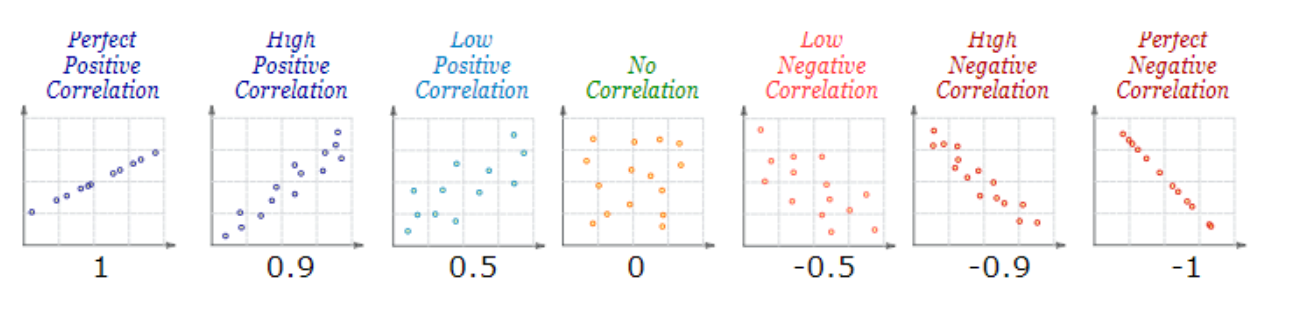

In [52]:
numeric_to_remove = []

In [53]:
# corr_df = X_train[columns_by_type['float64']].corr() # NOTA: Obtenemos la misma matriz de correlación con los datos sin escalar
corr_df = data_num_sc.corr()
px.imshow(corr_df, 
          labels=dict(color="Correlación"),
          x=corr_df.index, 
          y=corr_df.columns, 
          range_color=[-1, 1], 
          color_continuous_scale="oxy"
          )


In [54]:
correlated_features = set()
for i in range(len(corr_df.columns)):
    for j in range(i):
        if abs(corr_df.iloc[i, j]) > 0.7:
            colname = corr_df.columns[i]
            correlated_features.add(colname)
len(correlated_features)

11

In [55]:
correlated_features

{'acc_open_past_24mths',
 'annual_inc_joint',
 'avg_cur_bal',
 'bc_util',
 'fico_range_high',
 'installment',
 'last_fico_range_low',
 'mths_since_recent_bc_dlq',
 'open_rv_24m',
 'total_acc',
 'total_rev_hi_lim'}

In [56]:
X_train.drop(columns=correlated_features, inplace=True)
X_test.drop(columns=correlated_features, inplace=True)

data_num_sc.drop(columns=correlated_features, inplace=True)
columns_by_type['float64'] = columns_by_type['float64'].drop(correlated_features)


## Fechas

Las fechas no las ocuparemos a menos en este análisis. Aunque cabe destacar que podrían ocupar si se transforman a otro tipo de dato (e.g. crear "número de días desde..." y obtener la nueva variable usando una diferencia en días entre fechas).

In [57]:
for col in columns_by_type["datetime[ns]"]:
    print(data_filt[col].head(), sep)

0   1995-11-01
1   2003-10-01
2   1999-10-01
3   1983-11-01
4   2000-04-01
Name: earliest_cr_line, dtype: datetime64[ns] 
-------------------

0          NaT
1   2018-01-01
2          NaT
3          NaT
4   2018-01-01
Name: next_pymnt_d, dtype: datetime64[ns] 
-------------------

0   2016-10-01
1   2017-12-01
2   2017-03-01
3   2017-12-01
4   2017-12-01
Name: last_credit_pull_d, dtype: datetime64[ns] 
-------------------



In [58]:
X_train.drop(columns=columns_by_type["datetime[ns]"], inplace=True)
X_test.drop(columns=columns_by_type["datetime[ns]"], inplace=True)

## Factores

Para poder usar factores en el modelo, es mecesario convertirlas a variables dummies. Esto es, considerando la siguiente variable:

estado_civil|
------------|
soltero
casado
soltero
soltero
viudo

Al obtener las variables dummies de esta obtendriamos:

estado_civil_soltero|estado_civil_casado|estado_civil_viudo
---|---|---
1|0|0
0|1|0
1|0|0
1|0|0
0|0|1

Incluso se puede quitar uno de los niveles y dejarlo como el estado base:

estado_civil_casado|estado_civil_viudo
---|---
0|0
1|0
0|0
0|0
0|1


Si nuestra variable tiene muchos niveles, el crear variables dummies de esta puede hacer que nuestro dataset crezca en dimensión, complicando el entrenamiento del modelo. Para estos casos, se puede buscar la posibilidad de unir distintos niveles en uno sólo o eliminar la variable.

In [59]:
unique_values_by_column = X_train[columns_by_type["object"]].nunique().reset_index(name = "n")
unique_values_by_column

,index,n
0,member_id,17476
1,term,2
2,grade,7
3,sub_grade,35
4,emp_title,9706
5,emp_length,11
6,home_ownership,6
7,verification_status,3
8,pymnt_plan,2
9,desc,1290


In [60]:
px.bar(data_frame = unique_values_by_column, 
       x ="index", 
       y = "n", 
       title="Cantidad de niveles por factor", 
       labels={
           "index": "Nombre de la variable",
           "n": "Número de niveles"
           }
       )

Eliminamos las variables con más de 900 niveles.

In [61]:
drop_columns = columns_by_type["object"][unique_values_by_column.n > 900].to_list()
drop_columns

['member_id', 'emp_title', 'desc', 'title']

In [62]:
X_train.drop(columns=drop_columns, inplace=True)
X_test.drop(columns=drop_columns, inplace=True)

columns_by_type['object'] = columns_by_type['object'].drop(drop_columns)

In [63]:
X_train

,id,loan_amnt,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,purpose,zip_code,addr_state,dti,fico_range_low,mths_since_last_delinq,mths_since_last_record,open_acc,revol_bal,revol_util,initial_list_status,last_fico_range_high,mths_since_last_major_derog,application_type,dti_joint,verification_status_joint,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m,bc_open_to_buy,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc
23795,1643719,8000.0,36 months,7.49,A,A4,5 years,MORTGAGE,120000.0,Not Verified,n,debt_consolidation,812xx,CO,17.67,750.0,NaN,NaN,11.0,15544.0,42.6,f,794.0,NaN,Individual,NaN,NaN,0.0,103816.0,0.0,3.0,0.0,27.0,18347.0,33.0,0.0,7682.0,37.0,0.0,2.0,0.0,17205.0,0.0,146.0,318.0,25.0,25.0,2.0,28.0
24969,544148,22400.0,36 months,11.53,B,B5,1 year,RENT,62400.0,Source Verified,n,debt_consolidation,945xx,CA,16.67,685.0,NaN,NaN,14.0,11200.0,50.2,w,614.0,NaN,Individual,NaN,NaN,0.0,62439.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11100.0,0.0,91.0,97.0,2.0,2.0,0.0,2.0
3602,1267073,8000.0,36 months,13.59,C,C2,2 years,MORTGAGE,46332.0,Source Verified,n,debt_consolidation,917xx,CA,25.85,675.0,4.0,NaN,12.0,4488.0,45.3,w,689.0,NaN,Individual,NaN,NaN,115.0,96630.0,0.0,2.0,4.0,16.0,25159.0,75.0,2.0,1375.0,68.0,3.0,1.0,3.0,3719.0,0.0,179.0,46.0,9.0,9.0,1.0,9.0
10955,281318,8000.0,36 months,11.48,B,B5,10+ years,MORTGAGE,65000.0,Verified,n,vacation,760xx,TX,13.00,660.0,NaN,74.0,6.0,2886.0,70.4,w,694.0,NaN,Individual,NaN,NaN,1258.0,28470.0,2.0,2.0,4.0,6.0,25584.0,92.0,0.0,1452.0,89.0,0.0,13.0,3.0,1114.0,0.0,122.0,285.0,48.0,6.0,2.0,48.0
13729,1551399,16000.0,36 months,7.39,A,A4,6 years,RENT,90000.0,Verified,n,debt_consolidation,130xx,NY,10.40,675.0,13.0,NaN,6.0,8100.0,50.3,w,624.0,NaN,Individual,NaN,NaN,0.0,26331.0,0.0,2.0,0.0,25.0,18231.0,54.0,0.0,2670.0,53.0,0.0,4.0,2.0,3265.0,0.0,56.0,87.0,20.0,20.0,0.0,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9377,1419902,26450.0,36 months,6.99,A,A2,10+ years,OWN,580000.0,Verified,n,credit_card,100xx,NY,7.28,730.0,NaN,NaN,8.0,103784.0,95.4,w,754.0,NaN,Individual,NaN,NaN,0.0,613259.0,1.0,2.0,2.0,4.0,40911.0,78.0,0.0,29000.0,90.0,0.0,0.0,2.0,47216.0,0.0,162.0,221.0,17.0,4.0,1.0,17.0
7296,1548864,26000.0,36 months,11.99,C,C1,< 1 year,RENT,86586.0,Not Verified,n,debt_consolidation,330xx,FL,25.99,700.0,NaN,NaN,13.0,25922.0,73.6,w,734.0,NaN,Individual,NaN,NaN,0.0,112023.0,0.0,6.0,1.0,22.0,86101.0,72.0,3.0,9243.0,73.0,1.0,0.0,0.0,4959.0,0.0,208.0,154.0,8.0,8.0,0.0,25.0
17750,64679,6000.0,36 months,9.17,B,B1,3 years,OWN,65000.0,Not Verified,n,credit_card,070xx,NJ,6.22,660.0,37.0,NaN,13.0,9456.0,53.4,w,534.0,57.0,Individual,NaN,NaN,2021.0,9456.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5216.0,0.0,138.0,135.0,2.0,2.0,0.0,10.0
7298,1503632,16000.0,36 months,7.59,A,A3,10+ years,MORTGAGE,103000.0,Verified,n,debt_consolidation,337xx,FL,13.67,745.0,NaN,NaN,13.0,38560.0,42.3,f,774.0,NaN,Individual,NaN,NaN,0.0,445407.0,0.0,1.0,1.0,10.0,27051.0,87.0,0.0,23192.0,54.0,2.0,2.0,3.0,49586.0,0.0,159.0,216.0,15.0,10.0,4.0,15.0


In [64]:
 X_train = pd.get_dummies(X_train, columns=columns_by_type['object'])
 X_train

,id,loan_amnt,int_rate,annual_inc,dti,fico_range_low,mths_since_last_delinq,mths_since_last_record,open_acc,revol_bal,revol_util,last_fico_range_high,mths_since_last_major_derog,dti_joint,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m,bc_open_to_buy,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,term_ 36 months,term_ 60 months,grade_A,grade_B,...,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_f,initial_list_status_w,application_type_Individual,application_type_Joint App,verification_status_joint_Not Verified,verification_status_joint_Source Verified,verification_status_joint_Verified
23795,1643719,8000.0,7.49,120000.0,17.67,750.0,NaN,NaN,11.0,15544.0,42.6,794.0,NaN,NaN,0.0,103816.0,0.0,3.0,0.0,27.0,18347.0,33.0,0.0,7682.0,37.0,0.0,2.0,0.0,17205.0,0.0,146.0,318.0,25.0,25.0,2.0,28.0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
24969,544148,22400.0,11.53,62400.0,16.67,685.0,NaN,NaN,14.0,11200.0,50.2,614.0,NaN,NaN,0.0,62439.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11100.0,0.0,91.0,97.0,2.0,2.0,0.0,2.0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
3602,1267073,8000.0,13.59,46332.0,25.85,675.0,4.0,NaN,12.0,4488.0,45.3,689.0,NaN,NaN,115.0,96630.0,0.0,2.0,4.0,16.0,25159.0,75.0,2.0,1375.0,68.0,3.0,1.0,3.0,3719.0,0.0,179.0,46.0,9.0,9.0,1.0,9.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
10955,281318,8000.0,11.48,65000.0,13.00,660.0,NaN,74.0,6.0,2886.0,70.4,694.0,NaN,NaN,1258.0,28470.0,2.0,2.0,4.0,6.0,25584.0,92.0,0.0,1452.0,89.0,0.0,13.0,3.0,1114.0,0.0,122.0,285.0,48.0,6.0,2.0,48.0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0
13729,1551399,16000.0,7.39,90000.0,10.40,675.0,13.0,NaN,6.0,8100.0,50.3,624.0,NaN,NaN,0.0,26331.0,0.0,2.0,0.0,25.0,18231.0,54.0,0.0,2670.0,53.0,0.0,4.0,2.0,3265.0,0.0,56.0,87.0,20.0,20.0,0.0,42.0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9377,1419902,26450.0,6.99,580000.0,7.28,730.0,NaN,NaN,8.0,103784.0,95.4,754.0,NaN,NaN,0.0,613259.0,1.0,2.0,2.0,4.0,40911.0,78.0,0.0,29000.0,90.0,0.0,0.0,2.0,47216.0,0.0,162.0,221.0,17.0,4.0,1.0,17.0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
7296,1548864,26000.0,11.99,86586.0,25.99,700.0,NaN,NaN,13.0,25922.0,73.6,734.0,NaN,NaN,0.0,112023.0,0.0,6.0,1.0,22.0,86101.0,72.0,3.0,9243.0,73.0,1.0,0.0,0.0,4959.0,0.0,208.0,154.0,8.0,8.0,0.0,25.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
17750,64679,6000.0,9.17,65000.0,6.22,660.0,37.0,NaN,13.0,9456.0,53.4,534.0,57.0,NaN,2021.0,9456.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5216.0,0.0,138.0,135.0,2.0,2.0,0.0,10.0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
7298,1503632,16000.0,7.59,103000.0,13.67,745.0,NaN,NaN,13.0,38560.0,42.3,774.0,NaN,NaN,0.0,445407.0,0.0,1.0,1.0,10.0,27051.0,87.0,0.0,23192.0,54.0,2.0,2.0,3.0,49

# Imputación de datos faltantes

Como los modelos matemáticos no trabajan con valores faltantes, es necesario aplicar un tratamiento a estos, ya sea eliminando los casos o imputándolos. Para imputarlos podemos optar por métodos sencillos (media, mediana o moda de la variable) o ir por métodos un poco más elaborados (Multiple Imputation by Chained Equations, KNN, Exact Matrix Completion via Convex Optimization, etc.). 

Lo recomendable es hacer un análisis de los datos faltantes por variable antes de pensar en imputar los datos (ver: [To impute or not to impute?](https://towardsdatascience.com/to-impute-or-not-to-impute-a-practical-example-when-imputation-could-lead-to-wrong-conclusions-fd1e340d779a)).

En este caso, imputamos los valores faltantes en nuestro dataset de la manera más ingenua posible. Ponemos 99 en todos los valores faltantes. En los ejercicios vamos a pensar un poco sobre las implicaciones de esta imputación.

In [65]:
X_train_fact = X_train.fillna(99).drop("id", 1)
X_train_fact

,loan_amnt,int_rate,annual_inc,dti,fico_range_low,mths_since_last_delinq,mths_since_last_record,open_acc,revol_bal,revol_util,last_fico_range_high,mths_since_last_major_derog,dti_joint,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m,bc_open_to_buy,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,term_ 36 months,term_ 60 months,grade_A,grade_B,grade_C,...,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_f,initial_list_status_w,application_type_Individual,application_type_Joint App,verification_status_joint_Not Verified,verification_status_joint_Source Verified,verification_status_joint_Verified
23795,8000.0,7.49,120000.0,17.67,750.0,99.0,99.0,11.0,15544.0,42.6,794.0,99.0,99.0,0.0,103816.0,0.0,3.0,0.0,27.0,18347.0,33.0,0.0,7682.0,37.0,0.0,2.0,0.0,17205.0,0.0,146.0,318.0,25.0,25.0,2.0,28.0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
24969,22400.0,11.53,62400.0,16.67,685.0,99.0,99.0,14.0,11200.0,50.2,614.0,99.0,99.0,0.0,62439.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,11100.0,0.0,91.0,97.0,2.0,2.0,0.0,2.0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
3602,8000.0,13.59,46332.0,25.85,675.0,4.0,99.0,12.0,4488.0,45.3,689.0,99.0,99.0,115.0,96630.0,0.0,2.0,4.0,16.0,25159.0,75.0,2.0,1375.0,68.0,3.0,1.0,3.0,3719.0,0.0,179.0,46.0,9.0,9.0,1.0,9.0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
10955,8000.0,11.48,65000.0,13.00,660.0,99.0,74.0,6.0,2886.0,70.4,694.0,99.0,99.0,1258.0,28470.0,2.0,2.0,4.0,6.0,25584.0,92.0,0.0,1452.0,89.0,0.0,13.0,3.0,1114.0,0.0,122.0,285.0,48.0,6.0,2.0,48.0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0
13729,16000.0,7.39,90000.0,10.40,675.0,13.0,99.0,6.0,8100.0,50.3,624.0,99.0,99.0,0.0,26331.0,0.0,2.0,0.0,25.0,18231.0,54.0,0.0,2670.0,53.0,0.0,4.0,2.0,3265.0,0.0,56.0,87.0,20.0,20.0,0.0,42.0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9377,26450.0,6.99,580000.0,7.28,730.0,99.0,99.0,8.0,103784.0,95.4,754.0,99.0,99.0,0.0,613259.0,1.0,2.0,2.0,4.0,40911.0,78.0,0.0,29000.0,90.0,0.0,0.0,2.0,47216.0,0.0,162.0,221.0,17.0,4.0,1.0,17.0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
7296,26000.0,11.99,86586.0,25.99,700.0,99.0,99.0,13.0,25922.0,73.6,734.0,99.0,99.0,0.0,112023.0,0.0,6.0,1.0,22.0,86101.0,72.0,3.0,9243.0,73.0,1.0,0.0,0.0,4959.0,0.0,208.0,154.0,8.0,8.0,0.0,25.0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
17750,6000.0,9.17,65000.0,6.22,660.0,37.0,99.0,13.0,9456.0,53.4,534.0,57.0,99.0,2021.0,9456.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,5216.0,0.0,138.0,135.0,2.0,2.0,0.0,10.0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
7298,16000.0,7.59,103000.0,13.67,745.0,99.0,99.0,13.0,38560.0,42.3,774.0,99.0,99.0,0.0,445407.0,0.0,1.0,1.0,10.0,27051.0,87.0,0.0,23192.0,54.0,2.0,2.

In [66]:
#px.bar(pd.concat([X_train_fact, y_train], 1).corr()['loan_status'])

KeyboardInterrupt: ignored

In [67]:
data_plot = pd.concat([X_train_fact, y_train], 1)
data_plot.loan_status = data_plot.loan_status + np.random.normal(0, .1, len(data_plot))

In [68]:
#px.scatter(data_frame = data_plot, x = 'loan_status', y = 'last_fico_range_high', opacity = .5, title = 'last_fico_range_high vs. loan_status <br><span>Tiene ruido para facilitar la visualización</span>')

# Latent Discriminant Analysis

## Entrenamiento

In [69]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_fact, y_train)
train_pred = lda.predict(X_train_fact)
print(classification_report(y_train, train_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97     15674
         1.0       0.72      0.74      0.73      1802

    accuracy                           0.94     17476
   macro avg       0.84      0.85      0.85     17476
weighted avg       0.94      0.94      0.94     17476



Imaginemos que nuestro vector de etiquetas se ve así (0, 1, 1, 0, 1), estas son las etiquetas **reales**, y que el vector de **predicciones** se ve así (0, 0, 1, 0, 0).

real: (0, 1, 1, 0, 1) \
pred: (0, 0, 1, 0, 0)


La matriz de confusión para este caso se vería de la siguiente manera

*|1|0|
-|-|-|
**1**|1|2|
**0**|0|2|


*| no me pago (1) | me pago (0)
-----|-|-|
no me pago (1) | 1332 | 470
me pago (0) | 526 | 15148

In [70]:
confusion_matrix(y_train, train_pred)

array([[15148,   526],
       [  470,  1332]])

## Prueba

In [81]:
X_test

,id,loan_amnt,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,purpose,zip_code,addr_state,dti,fico_range_low,mths_since_last_delinq,mths_since_last_record,open_acc,revol_bal,revol_util,initial_list_status,last_fico_range_high,mths_since_last_major_derog,application_type,dti_joint,verification_status_joint,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m,bc_open_to_buy,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc
19603,271063,1500.0,36 months,8.94,A,A5,1 year,RENT,31000.0,Not Verified,n,major_purchase,064xx,CT,8.52,715.0,NaN,NaN,8.0,1649.0,6.0,f,749.0,NaN,Individual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2028,723250,16000.0,60 months,9.93,B,B2,2 years,MORTGAGE,84000.0,Verified,n,debt_consolidation,285xx,NC,28.13,725.0,20.0,NaN,7.0,8301.0,55.0,w,729.0,27.0,Individual,NaN,NaN,0.0,119090.0,2.0,3.0,1.0,12.0,110789.0,72.0,2.0,298.0,66.0,0.0,2.0,1.0,702.0,0.0,138.0,277.0,3.0,3.0,0.0,3.0
6425,935634,24000.0,60 months,13.11,B,B4,10+ years,MORTGAGE,107282.0,Verified,n,debt_consolidation,193xx,PA,20.94,715.0,NaN,NaN,10.0,15034.0,66.8,f,709.0,NaN,Individual,NaN,NaN,0.0,290969.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6311.0,0.0,131.0,164.0,9.0,8.0,4.0,15.0
8868,473804,20000.0,36 months,12.29,C,C1,2 years,RENT,86500.0,Source Verified,n,debt_consolidation,212xx,MD,20.01,670.0,9.0,NaN,13.0,38217.0,73.9,w,674.0,NaN,Individual,NaN,NaN,0.0,141035.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2754.0,0.0,254.0,227.0,4.0,4.0,0.0,15.0
14703,924089,16275.0,60 months,21.49,E,E3,1 year,MORTGAGE,45760.0,Verified,n,debt_consolidation,853xx,AZ,9.15,670.0,25.0,NaN,17.0,8476.0,44.8,f,614.0,25.0,Individual,NaN,NaN,0.0,180448.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,282.0,0.0,171.0,125.0,27.0,27.0,1.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16673,1577945,16800.0,36 months,11.47,B,B5,4 years,RENT,60000.0,Source Verified,n,debt_consolidation,921xx,CA,17.52,690.0,15.0,NaN,8.0,4759.0,48.6,w,674.0,15.0,Individual,NaN,NaN,0.0,16339.0,0.0,3.0,0.0,30.0,11580.0,31.0,0.0,382.0,34.0,0.0,5.0,2.0,18.0,0.0,102.0,127.0,62.0,30.0,0.0,66.0
3718,1294723,38400.0,36 months,16.02,C,C5,10+ years,RENT,125000.0,Source Verified,n,debt_consolidation,018xx,MA,27.67,735.0,NaN,NaN,21.0,24766.0,27.4,f,729.0,NaN,Individual,NaN,NaN,0.0,118480.0,2.0,5.0,0.0,26.0,69574.0,70.0,4.0,12107.0,55.0,1.0,0.0,4.0,45926.0,0.0,270.0,238.0,2.0,2.0,0.0,2.0
13792,1506322,17000.0,60 months,18.99,D,D3,10+ years,RENT,37000.0,Source Verified,n,debt_consolidation,606xx,IL,20.56,690.0,NaN,NaN,12.0,21355.0,58.5,w,704.0,NaN,Individual,NaN,NaN,0.0,22594.0,0.0,1.0,2.0,8.0,1239.0,60.0,0.0,5223.0,59.0,2.0,0.0,1.0,12767.0,0.0,74.0,123.0,23.0,8.0,0.0,23.0
8571,371023,28000.0,36 months,11.53,B,B5,10+ years,MORTGAGE,98976.0,Source Verified,n,debt_consolidation,922xx,CA,15.18,685.0,NaN,NaN,11.0,46116.0,99.0,w,699.0,NaN,Individual,NaN,NaN,0.0,431599.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,121.0,352.0,46.0,6.0,3.0,91.0


In [82]:
X_test_fact = pd.get_dummies(X_test, columns=columns_by_type['object']).fillna(99)
X_test_fact

,id,loan_amnt,int_rate,annual_inc,dti,fico_range_low,mths_since_last_delinq,mths_since_last_record,open_acc,revol_bal,revol_util,last_fico_range_high,mths_since_last_major_derog,dti_joint,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m,bc_open_to_buy,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,term_ 36 months,term_ 60 months,grade_A,grade_B,...,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_f,initial_list_status_w,application_type_Individual,application_type_Joint App,verification_status_joint_Not Verified,verification_status_joint_Source Verified,verification_status_joint_Verified
19603,271063,1500.0,8.94,31000.0,8.52,715.0,99.0,99.0,8.0,1649.0,6.0,749.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,0.0,99.0,99.0,99.0,99.0,99.0,99.0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
2028,723250,16000.0,9.93,84000.0,28.13,725.0,20.0,99.0,7.0,8301.0,55.0,729.0,27.0,99.0,0.0,119090.0,2.0,3.0,1.0,12.0,110789.0,72.0,2.0,298.0,66.0,0.0,2.0,1.0,702.0,0.0,138.0,277.0,3.0,3.0,0.0,3.0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
6425,935634,24000.0,13.11,107282.0,20.94,715.0,99.0,99.0,10.0,15034.0,66.8,709.0,99.0,99.0,0.0,290969.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,6311.0,0.0,131.0,164.0,9.0,8.0,4.0,15.0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
8868,473804,20000.0,12.29,86500.0,20.01,670.0,9.0,99.0,13.0,38217.0,73.9,674.0,99.0,99.0,0.0,141035.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,2754.0,0.0,254.0,227.0,4.0,4.0,0.0,15.0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
14703,924089,16275.0,21.49,45760.0,9.15,670.0,25.0,99.0,17.0,8476.0,44.8,614.0,25.0,99.0,0.0,180448.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,282.0,0.0,171.0,125.0,27.0,27.0,1.0,27.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16673,1577945,16800.0,11.47,60000.0,17.52,690.0,15.0,99.0,8.0,4759.0,48.6,674.0,15.0,99.0,0.0,16339.0,0.0,3.0,0.0,30.0,11580.0,31.0,0.0,382.0,34.0,0.0,5.0,2.0,18.0,0.0,102.0,127.0,62.0,30.0,0.0,66.0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
3718,1294723,38400.0,16.02,125000.0,27.67,735.0,99.0,99.0,21.0,24766.0,27.4,729.0,99.0,99.0,0.0,118480.0,2.0,5.0,0.0,26.0,69574.0,70.0,4.0,12107.0,55.0,1.0,0.0,4.0,45926.0,0.0,270.0,238.0,2.0,2.0,0.0,2.0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
13792,1506322,17000.0,18.99,37000.0,20.56,690.0,99.0,99.0,12.0,21355.0,58.5,704.0,99.0,99.0,0.0,22594.0,0.0,1.0,2.0,8.0,1239.0,60.0,0.0,5223.0,59.0,2.0,0.0,1.0,12767.0,0.0,74.0,123.0,23.0,8.0,0.0,23.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
8571,371023,28000.0,11.53,98976.0,15.18,685.0,99.0,99.0,11.0,46116.0,99.0,699.0,99.0,99.0,0.0,431599.0,99.0,99.0,99.0

In [83]:
missing_cols = set( X_train_fact.columns ) - set( X_test_fact.columns )
missing_cols

{'home_ownership_NONE',
 'home_ownership_OTHER',
 'zip_code_022xx',
 'zip_code_035xx',
 'zip_code_036xx',
 'zip_code_043xx',
 'zip_code_044xx',
 'zip_code_045xx',
 'zip_code_046xx',
 'zip_code_047xx',
 'zip_code_050xx',
 'zip_code_051xx',
 'zip_code_081xx',
 'zip_code_096xx',
 'zip_code_159xx',
 'zip_code_167xx',
 'zip_code_169xx',
 'zip_code_214xx',
 'zip_code_215xx',
 'zip_code_216xx',
 'zip_code_250xx',
 'zip_code_251xx',
 'zip_code_256xx',
 'zip_code_258xx',
 'zip_code_259xx',
 'zip_code_263xx',
 'zip_code_264xx',
 'zip_code_266xx',
 'zip_code_267xx',
 'zip_code_279xx',
 'zip_code_289xx',
 'zip_code_396xx',
 'zip_code_413xx',
 'zip_code_418xx',
 'zip_code_438xx',
 'zip_code_474xx',
 'zip_code_479xx',
 'zip_code_498xx',
 'zip_code_542xx',
 'zip_code_545xx',
 'zip_code_556xx',
 'zip_code_565xx',
 'zip_code_566xx',
 'zip_code_567xx',
 'zip_code_576xx',
 'zip_code_580xx',
 'zip_code_583xx',
 'zip_code_587xx',
 'zip_code_590xx',
 'zip_code_592xx',
 'zip_code_619xx',
 'zip_code_623xx',
 

In [84]:
for c in missing_cols:
    X_test_fact[c] = 0
X_test_fact = X_test_fact[X_train_fact.columns]
X_test_fact

,loan_amnt,int_rate,annual_inc,dti,fico_range_low,mths_since_last_delinq,mths_since_last_record,open_acc,revol_bal,revol_util,last_fico_range_high,mths_since_last_major_derog,dti_joint,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m,bc_open_to_buy,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,term_ 36 months,term_ 60 months,grade_A,grade_B,grade_C,...,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_f,initial_list_status_w,application_type_Individual,application_type_Joint App,verification_status_joint_Not Verified,verification_status_joint_Source Verified,verification_status_joint_Verified
19603,1500.0,8.94,31000.0,8.52,715.0,99.0,99.0,8.0,1649.0,6.0,749.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,0.0,99.0,99.0,99.0,99.0,99.0,99.0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
2028,16000.0,9.93,84000.0,28.13,725.0,20.0,99.0,7.0,8301.0,55.0,729.0,27.0,99.0,0.0,119090.0,2.0,3.0,1.0,12.0,110789.0,72.0,2.0,298.0,66.0,0.0,2.0,1.0,702.0,0.0,138.0,277.0,3.0,3.0,0.0,3.0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
6425,24000.0,13.11,107282.0,20.94,715.0,99.0,99.0,10.0,15034.0,66.8,709.0,99.0,99.0,0.0,290969.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,6311.0,0.0,131.0,164.0,9.0,8.0,4.0,15.0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
8868,20000.0,12.29,86500.0,20.01,670.0,9.0,99.0,13.0,38217.0,73.9,674.0,99.0,99.0,0.0,141035.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,2754.0,0.0,254.0,227.0,4.0,4.0,0.0,15.0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
14703,16275.0,21.49,45760.0,9.15,670.0,25.0,99.0,17.0,8476.0,44.8,614.0,25.0,99.0,0.0,180448.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,282.0,0.0,171.0,125.0,27.0,27.0,1.0,27.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16673,16800.0,11.47,60000.0,17.52,690.0,15.0,99.0,8.0,4759.0,48.6,674.0,15.0,99.0,0.0,16339.0,0.0,3.0,0.0,30.0,11580.0,31.0,0.0,382.0,34.0,0.0,5.0,2.0,18.0,0.0,102.0,127.0,62.0,30.0,0.0,66.0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
3718,38400.0,16.02,125000.0,27.67,735.0,99.0,99.0,21.0,24766.0,27.4,729.0,99.0,99.0,0.0,118480.0,2.0,5.0,0.0,26.0,69574.0,70.0,4.0,12107.0,55.0,1.0,0.0,4.0,45926.0,0.0,270.0,238.0,2.0,2.0,0.0,2.0,1,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
13792,17000.0,18.99,37000.0,20.56,690.0,99.0,99.0,12.0,21355.0,58.5,704.0,99.0,99.0,0.0,22594.0,0.0,1.0,2.0,8.0,1239.0,60.0,0.0,5223.0,59.0,2.0,0.0,1.0,12767.0,0.0,74.0,123.0,23.0,8.0,0.0,23.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
8571,28000.0,11.53,98976.0,15.18,685.0,99.0,99.0,11.0,46116.0,99.0,699.0,99.0,99.0,0.0,431599.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0

In [85]:
test_pred = lda.predict(X_test_fact)
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96      6733
         1.0       0.64      0.66      0.65       757

    accuracy                           0.93      7490
   macro avg       0.80      0.81      0.80      7490
weighted avg       0.93      0.93      0.93      7490



In [86]:
print(classification_report(y_train, train_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97     15674
         1.0       0.72      0.74      0.73      1802

    accuracy                           0.94     17476
   macro avg       0.84      0.85      0.85     17476
weighted avg       0.94      0.94      0.94     17476



Comparación de precisión obtenida en el set de entrenamiento y el set de prueba.

In [87]:
print(
    lda.score(X_train_fact, y_train), 
    lda.score(X_test_fact, y_test)
)

0.9430075532158388 0.9275033377837116


## ¿Cómo afecta cada variable?

In [88]:
coef_df = pd.DataFrame(lda.coef_[0], X_train_fact.columns, ["coef_"])
print(lda.intercept_)
coef_df

[19.57445769]


,coef_
loan_amnt,0.000041
int_rate,-0.240972
annual_inc,-0.000003
dti,0.010181
fico_range_low,0.020449
...,...
application_type_Individual,1.629050
application_type_Joint App,-1.629050
verification_status_joint_Not Verified,-1.643681
verification_status_joint_Source Verified,-1.418340


In [89]:
px.bar(coef_df.reset_index(), 'coef_', 'index')

In [90]:
X_test.loan_amnt * 10e-6

19603    0.01500
2028     0.16000
6425     0.24000
8868     0.20000
14703    0.16275
          ...   
16673    0.16800
3718     0.38400
13792    0.17000
8571     0.28000
122      0.10000
Name: loan_amnt, Length: 7490, dtype: float64

In [91]:
y_train[train_pred == 0]

23795    0.0
24969    0.0
3602     0.0
10955    0.0
13729    0.0
        ... 
10208    0.0
9377     0.0
7296     0.0
7298     0.0
17695    0.0
Name: loan_status, Length: 15618, dtype: float64

In [92]:
np.dot(lda.coef_, X_train_fact.loc[9377, :]) + lda.intercept_

array([-9.4050492])

In [93]:
y_train[train_pred == 1]

16058    1.0
16330    1.0
11021    0.0
19026    1.0
20096    0.0
        ... 
576      0.0
14719    0.0
10148    1.0
4833     1.0
17750    0.0
Name: loan_status, Length: 1858, dtype: float64

In [94]:
np.dot(lda.coef_, X_train_fact.loc[14719, :]) + lda.intercept_

array([2.06851388])

## LDA para reducir dimensión

In [95]:
X_proj = lda.transform(X_train_fact)
X_proj.shape

(17476, 1)

In [96]:
X_proj

array([[-0.74836444],
       [ 1.67762225],
       [-0.80867941],
       ...,
       [ 2.25323574],
       [-0.99791177],
       [ 0.25255178]])

In [97]:
probs = lda.predict_proba(X_train_fact)

In [98]:
probs[0]

array([9.99359186e-01, 6.40814398e-04])

In [99]:
tol = 1e-3
for i, p in enumerate(probs):
    if .5-tol < p[0] < .5 + tol:
        print(i, p)

4558 [0.49903194 0.50096806]


In [100]:
line = X_proj[4558]
line[0]

1.8844782660771093

In [101]:
fig = px.scatter()
fig.add_scatter(x = X_proj[y_train == 0, 0], y = np.random.rand(len(X_proj[y_train==0])), mode = "markers", opacity=.5, name = "normal")
fig.add_scatter(x = X_proj[y_train == 1, 0], y = np.random.rand(len(X_proj[y_train==1])), mode = "markers", opacity = .5, name = "default")
fig.add_vline(x = line[0], line_dash = 'dash')

fig.update_layout(
    title="Reducción de la dimensión de LDA",
    xaxis_title="LDA1<br><sup>Pese a que los datos se muestran en dos dimensiones, la proyección sólo fue a una (= n_clases - 1)<br>Se agrego aleatoriedad al eje y para facilitar la visualización</sup>",
    legend_title="Etiqueta",
    font=dict(
        size=18
    )
)

fig.show()

# Ejercicios


## Factores

### Condensar niveles

Condensar niveles de factores usualmente es antecedido por un análisis por variable comparando la relación entre cada nivel, la variable de respuesta (en este caso ```loan_status```) y otras covariables. De este modo, niveles que aparentan tener la misma relación con la variable de respuesta pueden juntarse en uno solo; Algunas veces, mejorando el desempeño del modelo y reduciendo la dimensionalidad (y con esto el tiempo de cómputo en algunos casos).

Sin embargo, si se tiene una gran cantidad de factores como covariables y estos a su vez tienen muchos niveles, puede llegar a ser un trabajo arduo que no compense la mejora obtenida en el desempeño del modelo o la rapidez del entrenamiento.

Para este ejercicio, use su intuición en lugar de hacer estas comparaciones. Tampoco es necesario considerar todos los factores, con una cantidad pequeña (por ejemplo, a lo más 3) es suficiente.

1. Condense los niveles de factores que usted considere pueden pertenecer a uno sólo. Puede comenzar con la variable ```home_ownership```, condensando en un nivel llamado ```not_owned``` a todos los niveles que no son ```OWN```.
2. Entrene LDA con estos cambios y compare los resultados obtenidos. ¿Mejoró el modelo?

## Imputación (opcional)

### Constante

1. ¿Qué problemas tiene imputar un valor constante en todas las variables con datos faltantes? Piense en la escala de las variables
    2. ¿Cómo afecta a la estandarización de las variables?
    3. ¿Qué relación tiene con los outliers?
2. ¿Por qué en este caso no presentó problemas aparentes?

### Media, mediana y moda

1. Cambiar la imputación realizada por la media, mediana y moda (tres ejercicios diferentes, realizando uno esta bien) y comparar los resultados obtenido con los vistos en el notebook.
2. ¿Qué implica llenar los valores valores vacios con este tipo de valores? Tome como ejemplo la variable ```mths_since_last_delinq```, ¿qué asumimos de las personas que no han delinquido?

Nota: Para familiarizarse con pandas, es un buen ejercicio realizarlo utilizando sólo pandas. Pero también puede utilizar [```sklearn.impute.SimpleImputer```](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)

### KNN (más opcional)

1. Realice la imputación de los valores con KNN y compare los resultados obtenidos.
2. ¿Cómo funciona esta imputación y qué implica para los valores perdidos?

Nota: Puede usar la implementación realizada en [```fancyimpute```](https://github.com/iskandr/fancyimpute)

# Ligas interesantes

- [BASIC LITERACY OF STATISTICS — 3](https://medium.com/@yohoshiva1609/basic-literacy-of-statistics-3-bc9f5a69f116)
- [Sobre la estandarización en variables dummies](https://stats.stackexchange.com/questions/463690/multiple-regression-with-mixed-continuous-categorical-variables-dummy-coding-s)

## TODO

- Agregar liga a matriz de confusion y metricas